# Developing an Information Retrieval System with Document Ranking

This project aims to augment the Information Retrieval (IR) system developed in the previous assignments by incorporating different Document Ranking strategies. You should use the Cranfield collection as the dataset. You can find
that in the original format here or in the TREC XML format with binary tagging here.


## Project Overview

In this project, you will implement three different approaches for document ranking, including the vector space model,
the binary independence model, and the language model. Then, you need to compare these ranking models resorting
to the evaluation criteria in Lecture 7. Key components and functionalities are as follows:


### ⬜ Document Preprocessing

Your project will begin by reading and preprocessing a collection of text documents
– for each document you only need to retain the text with TITLE and TEXT tags. The dataset also contains
queries and relevant documents to each query which will be useful in the evaluation phase.


In [1]:
from pathlib import Path  # For standard paths that work on both windows and linux
import xml.etree.ElementTree as ET  # For reading xml files
from nltk.tokenize import RegexpTokenizer  # For tokenization
from nltk.stem import PorterStemmer  # For stemming
import numpy as np
import math  # For calculating idf (math.log(N/df))
from collections import Counter  # For calculating query's terms frequency
import matplotlib.pyplot as plt  # For 11-point interpolated average precision

In [2]:
tokenizer = RegexpTokenizer(r"\w+")
ps = PorterStemmer()

In [3]:
DOCS_PATH = Path("cranfield-dataset") / "cran.all.1400.xml"

root = ET.parse(DOCS_PATH).getroot()


for i, doc in enumerate(root.findall("doc")):

    print(f"======== DOC {i} ========")

    print(doc.find("text").text[:200], "...", sep="")

    if i >= 1:
        break

======== DOC 0 ========
experimental investigation of the aerodynamics of a
wing in a slipstream .
  an experimental study of a wing in a propeller slipstream was
made in order to determine the spanwise distribution of the l...
======== DOC 1 ========
simple shear flow past a flat plate in an incompressible fluid of small
viscosity .
in the study of high-speed viscous flow past a two-dimensional body it
is usually necessary to consider a curved sho...


In [4]:
docs = []
docs_tokens = []
collection_tokens = []
posting_list = {}

for doc_id, doc in enumerate(root.findall("doc")):
    text = doc.find("text").text or ""
    tokens = tokenizer.tokenize(text)
    tokens = [ps.stem(token) for token in tokens]

    docs.append(text)
    docs_tokens.append(tokens)

    for token in tokens:
        collection_tokens.append(token)

    for term in tokens:
        if posting_list.get(term) == None:
            posting_list[term] = {}

        if posting_list[term].get(doc_id) == None:
            posting_list[term][doc_id] = 0

        posting_list[term][doc_id] += 1

In [5]:
print(f"but({len(posting_list['but'])} docs): [doc_id: frequency]", posting_list["but"])

but(219 docs): [doc_id: frequency] {13: 2, 24: 1, 27: 1, 43: 1, 48: 2, 61: 1, 65: 1, 71: 2, 93: 1, 109: 2, 113: 1, 115: 1, 124: 1, 125: 1, 131: 1, 137: 1, 139: 1, 148: 1, 151: 1, 152: 1, 155: 2, 159: 1, 167: 1, 172: 1, 175: 1, 178: 1, 184: 1, 187: 1, 188: 1, 190: 1, 192: 1, 198: 2, 200: 1, 201: 4, 203: 1, 205: 1, 208: 1, 209: 1, 211: 2, 213: 1, 220: 1, 226: 1, 228: 1, 240: 1, 243: 1, 246: 1, 251: 2, 254: 2, 260: 1, 265: 1, 271: 1, 282: 1, 283: 1, 291: 1, 295: 1, 328: 4, 337: 2, 346: 1, 347: 1, 351: 1, 369: 1, 374: 1, 389: 1, 403: 2, 416: 1, 430: 1, 440: 1, 451: 1, 458: 2, 476: 2, 483: 1, 489: 1, 498: 2, 510: 1, 514: 1, 518: 1, 519: 1, 520: 1, 521: 1, 526: 1, 535: 1, 544: 1, 546: 1, 555: 1, 561: 1, 563: 1, 565: 1, 566: 1, 568: 1, 569: 1, 571: 1, 588: 1, 594: 1, 599: 1, 603: 1, 635: 1, 639: 1, 642: 1, 651: 1, 659: 1, 660: 1, 662: 1, 666: 1, 670: 1, 672: 1, 678: 1, 684: 2, 685: 1, 691: 1, 703: 2, 717: 1, 720: 1, 726: 1, 730: 1, 738: 1, 747: 1, 751: 1, 752: 2, 755: 1, 756: 2, 759: 1, 762: 

In [6]:
# test if above result is correct
num_but_in_doc_13 = sum(np.array(docs[13].split()) == "but")
print("Number of 'but's in doc_13 =", num_but_in_doc_13)

Number of 'but's in doc_13 = 2


In [7]:
def format_results(docs_scores, k, print_results=False):
    result_docs_ids = docs_scores.argsort()[-k:][::-1]

    results = [
        {"id": result_docs_ids[i], "score": docs_scores[result_docs_ids[i]]}
        for i in range(len(result_docs_ids))
    ]

    if print_results:
        for i, result in enumerate(results):
            print(f"====================== Result {i + 1} ======================")
            print(result)
            print(docs[result["id"]][:100].replace("\n", ""), "...", sep="")
            print()

    return results

### ⬜ Document Ranking – Space Vector Model

You will implement a function for document ranking utilizing
the tf-idf weighting approach. The function will take as input a query text and an integer indicating the number
of top documents to be retrieved. To this end, you might need to store additional information about the ”term
frequency” in each document and the ”document frequency” of each term. A good representation and sufficient
data storage facilitate you in implementing other models too. You can choose between <u style="color:orangered">different tf-idf variants</u>
and need to discuss why your chosen approach is preferred.


#### ◼ tf-idf variants

I'm using ntc(regarding to slides) for both documents and queries.

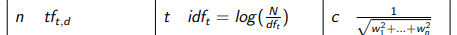

This is perfect because it considers the number of tokens occurring in a document or query.

If someone repeats a word twice in a query it means the word is more important.


In [8]:
def cosine_score(query, k, print_results=False):
    query = [ps.stem(token) for token in tokenizer.tokenize(query)]

    query_term_frequency = Counter(query)

    docs_scores = np.zeros(len(docs))

    for term in posting_list:
        idf = math.log(
            len(docs) / len(posting_list[term]), 10
        )  # Log base is 10 in the slides

        term_query_weight = query_term_frequency[term] * idf

        for doc_id in posting_list[term]:
            tf = posting_list[term][doc_id]

            term_doc_weight = tf * idf

            docs_scores[doc_id] += term_query_weight * term_doc_weight

    for i in range(len(docs_scores)):
        docs_scores[i] /= len(docs_tokens[i]) or 1

    return format_results(docs_scores, k, print_results)

In [9]:
cosine_score("papers on shock-sound wave interaction", 3, print_results=True)

====================== Result 1 ======================
{'id': 63, 'score': 0.18509858343250643}
unsteady oblique interaction of a shock wave with planedisturbances .  analysis is made of the flo...

====================== Result 2 ======================
{'id': 401, 'score': 0.09745768270811708}
magnetohydrodynamics shocks .  a mathematical treatment of the coupled motion ofhydrodynamic flow ...

====================== Result 3 ======================
{'id': 64, 'score': 0.09550694068965461}
convection of a pattern of vorticity through a shockwave .  an arbitrary weak spatial distribution...



[{'id': 63, 'score': 0.18509858343250643},
 {'id': 401, 'score': 0.09745768270811708},
 {'id': 64, 'score': 0.09550694068965461}]

### ⬜ Document Ranking – Probabilistic Model

You will implement a function for document ranking utilizing
the Okapi BM25 basic weighting approach. The function will take as input a query text and an integer indicating
the number of top documents to be retrieved. You do not need to fine-tune parameters b, k1, k3. Nevertheless,
you have to <u>argue why the acquired parameters make sense</u>.


### ⬜ Long queries – Probabilistic Model (Optional)

Handle long queries by having your function <u>alternatively switch</u> between Okapi BM25 approaches based on the query length.


#### ◼ argue why the acquired parameters make sense

regarding to slides:
The above tuning parameters should ideally be set to optimize performance
on a development test collection. In the absence of such optimization,
experiments have shown reasonable values are to
<u style="color:orangered">set k1 and k3 to a value between 1.2 and 2</u> and <u style="color:orangered">b = 0.75</u>

k1 = 1.5 makes sense because when tf becomes twice, the rsv changes less than twice.
b = .75 makes sense because when a document is twice bigger it gets a score more than twice smaller.
k3 = 1.5 makes sense. the same reason for k1 but this time for query.


In [10]:
avg_doc_length = sum([len(doc) for doc in docs_tokens]) / len(docs_tokens)

In [11]:
def rsv_score(query, k, print_results=False):
    query = [ps.stem(token) for token in tokenizer.tokenize(query)]

    k1, k3, b = 1.5, 1.5, 0.75
    threshold = 10

    if len(query) < threshold:
        k3 = 0  # If query is not long, don't consider k3.

    docs_scores = np.zeros(len(docs))

    query_term_frequency = Counter(query)

    for doc_id in range(len(docs)):
        for term in set(query):
            if term in docs_tokens[doc_id]:
                idf = math.log(len(docs) / len(posting_list[term]), 10)
                tf_d = posting_list[term][doc_id]
                tf_q = query_term_frequency[term]

                factor1 = ((k1 + 1) * tf_d) / (
                    k1 * ((1 - b) + b * len(docs_tokens[doc_id]) / avg_doc_length)
                    + tf_d
                )

                factor2 = ((k3 + 1) * tf_q) / (k3 + tf_q)

                docs_scores[doc_id] += idf * factor1 * factor2

    return format_results(docs_scores, k, print_results)

In [12]:
rsv_score("papers on shock-sound wave interaction", 3, print_results=True)

====================== Result 1 ======================
{'id': 63, 'score': 8.064827521193093}
unsteady oblique interaction of a shock wave with planedisturbances .  analysis is made of the flo...

====================== Result 2 ======================
{'id': 131, 'score': 6.000580014244672}
viscosity effects in sound waves of finite amplitude:in survey in mechanics .  this article has as...

====================== Result 3 ======================
{'id': 169, 'score': 5.864529920069774}
the interaction of a reflected shock wave with theboundary layer in a shock tube .  ideally, the r...



[{'id': 63, 'score': 8.064827521193093},
 {'id': 131, 'score': 6.000580014244672},
 {'id': 169, 'score': 5.864529920069774}]

### ⬜ Document Ranking – Language Model

You will implement a function for document ranking utilizing
the language model. The function will take as input a query text and an integer indicating the number of top
documents to be retrieved. You can choose between Dirichlet smoothing or Jelinek-Mercer smoothing to avoid
zeroes. You do not need to fine-tune parameters λ or α. Albeit, you need to discuss why your chosen methods
and parameters are preferred.


#### ◼ discuss why your chosen methods and parameters are preferred

Jelinek-Mercer because:

- It has good performance
- Easy to implement
- Fast (because we pre-compute collection model and document model)

lambda = 0.5 because it is 0.5 in slides example and makes sense.
when lambda = 0.5, we calculate score by paying attention to probability of occurring term in a document and probability of occurring term in a collection equally. in this way, less frequent terms become more important as much as they should. when a term has high collection frequency, the term increases scores of all documents, so it doesn't make a significant difference. but when a term is rare it just increases scores of the documents that it occurred in; hence this documents get a high score.


In [13]:
# Number of occurrences in the collection for each term.
collection_frequency = Counter(collection_tokens)
print({term: collection_frequency[term] for term in collection_tokens[:3]})

{'experiment': 470, 'investig': 524, 'of': 12671}


In [14]:
# Probability of occurrence in the collection for each term.
collection_model = {
    key: collection_frequency[key] / len(collection_tokens)
    for key in collection_frequency
}
print({term: collection_model[term] for term in collection_tokens[:3]})

{'experiment': 0.0020734531818683137, 'investig': 0.002311679717657439, 'of': 0.055899415462666815}


In [15]:
# Sum of all probabilities must be one. (Just for testing)
sum([collection_model[term] for term in collection_model])

1.0000000000000562

In [16]:
# Probability of occurrence in the documents.
docs_models = [
    {term: tf / len(doc_tokens) for term, tf in Counter(doc_tokens).items()}
    for doc_tokens in docs_tokens
]

for i in range(3):
    print(f"doc_{i}:", docs_models[i])

doc_0: {'experiment': 0.014388489208633094, 'investig': 0.007194244604316547, 'of': 0.07194244604316546, 'the': 0.08633093525179857, 'aerodynam': 0.007194244604316547, 'a': 0.050359712230215826, 'wing': 0.02158273381294964, 'in': 0.02877697841726619, 'slipstream': 0.03597122302158273, 'an': 0.02158273381294964, 'studi': 0.007194244604316547, 'propel': 0.007194244604316547, 'wa': 0.02877697841726619, 'made': 0.014388489208633094, 'order': 0.007194244604316547, 'to': 0.03597122302158273, 'determin': 0.007194244604316547, 'spanwis': 0.007194244604316547, 'distribut': 0.007194244604316547, 'lift': 0.02877697841726619, 'increas': 0.007194244604316547, 'due': 0.014388489208633094, 'at': 0.014388489208633094, 'differ': 0.02158273381294964, 'angl': 0.007194244604316547, 'attack': 0.007194244604316547, 'and': 0.007194244604316547, 'free': 0.007194244604316547, 'stream': 0.007194244604316547, 'veloc': 0.007194244604316547, 'ratio': 0.007194244604316547, 'result': 0.007194244604316547, 'were': 0.

In [17]:
# Sum of all probabilities must be one. (Just for testing)
for i in range(3):
    print(f"doc_{i}:", sum([docs_models[i][term] for term in docs_models[i]]))

doc_0: 0.9999999999999981
doc_1: 1.0000000000000009
doc_2: 1.0000000000000002


In [18]:
def language_model_score(query, k, print_results=False):
    query = [ps.stem(token) for token in tokenizer.tokenize(query)]

    l = 0.5

    docs_scores = np.ones(len(docs))

    for doc_id in range(len(docs)):
        for term in query:
            docs_scores[doc_id] *= l * (docs_models[doc_id].get(term) or 0) + (
                1 - l
            ) * (collection_model.get(term) or 1)

    return format_results(docs_scores, k, print_results)

In [19]:
# TODO: Fix error when query has a word that collection doesn't for all three models

In [20]:
language_model_score("papers on shock-sound wave interaction", 3, print_results=True)

====================== Result 1 ======================
{'id': 63, 'score': 4.542787301559045e-13}
unsteady oblique interaction of a shock wave with planedisturbances .  analysis is made of the flo...

====================== Result 2 ======================
{'id': 169, 'score': 6.384999445745297e-15}
the interaction of a reflected shock wave with theboundary layer in a shock tube .  ideally, the r...

====================== Result 3 ======================
{'id': 131, 'score': 5.940336349852554e-15}
viscosity effects in sound waves of finite amplitude:in survey in mechanics .  this article has as...



[{'id': 63, 'score': 4.542787301559045e-13},
 {'id': 169, 'score': 6.384999445745297e-15},
 {'id': 131, 'score': 5.940336349852554e-15}]

### ⬜ Compering Document Ranking Model

You will need to compare these three approaches for document
ranking based on an evaluation you learned in Lecture 7. You are provided with a set of queries and their
relevant documents, and you need to utilize these queries during your evaluation. You are suggested to use
11-point interpolated average precision for at least a few queries; however, you might resort to other criteria or
have a number of queries tested. You may also introduce your own evaluation approach if you are utilizing the
Cranfield collection in its original format, although you may also refer to this to change the relevancies of the
original format.


In [21]:
QUERIES_PATH = Path("cranfield-dataset") / "cran.qry.xml"

root = ET.parse(QUERIES_PATH).getroot()

queries = []

for qry in root.findall("top"):
    queries.append(qry.find("title").text)

for i in range(2):
    print(f"========================= QUERY {i} =========================")
    print(queries[i])
    print()

========================= QUERY 0 =========================

what similarity laws must be obeyed when constructing aeroelastic models
of heated high speed aircraft .


========================= QUERY 1 =========================

what are the structural and aeroelastic problems associated with flight
of high speed aircraft .




In [22]:
NUM_QUERIES = 225
RELATED_DOCS_PATH = Path("cranfield-dataset") / "cranqrel.trec.txt"

related_docs = [[] for _ in range(NUM_QUERIES)]

with open(RELATED_DOCS_PATH) as f:
    for line in f.readlines():
        query_info = [int(info) for info in line.split()]
        if query_info[3] == 1:
            related_docs[query_info[0] - 1].append(query_info[2] - 1)

print(related_docs[2:5])

[[4, 5, 89, 90, 118, 143, 180, 398], [235, 165], [551, 400, 1296, 1295]]


In [23]:
query_number = 3

print(f"### QUERY {query_number} ###")
print(queries[query_number])
print()
print(f"### RELEVANT DOCS TO QUERY {query_number} ###")
for doc_id in related_docs[query_number]:
    print(f"================ DOC {doc_id} ================")
    print(docs[doc_id][0:200], "...", sep="")

### QUERY 3 ###

can a criterion be developed to show empirically the validity of flow
solutions for chemically reacting gas mixtures based on the simplifying
assumption of instantaneous local chemical equilibrium .


### RELEVANT DOCS TO QUERY 3 ###
================ DOC 235 ================
criteria for thermodynamic equilibrium in gas flow .
  when gases flow at high velocity, the rates
of internal processes may not be fast enough to
maintain thermodynamic equilibrium .  by defining
qua...
================ DOC 165 ================
flow of chemically reacting gas mixtures .
  suitable forms of the equations
for the flow of an inviscid,
non-heat-conducting gas in which chemical
reactions are occurring are derived .
the effects of...


In [24]:
def calc_precession_recall(query_number, results):
    true_positive = 0

    for result in results:
        if result["id"] in related_docs[query_number]:
            true_positive += 1

    precession = true_positive / len(results)

    recall = true_positive / len(related_docs[query_number])

    return precession, recall

In [25]:
query_number = 3
print("RELATED_DOCS:", related_docs[query_number])
results = rsv_score(queries[query_number], k=2)
print(f"RESULTS({len(results)}):", results)
precession, recall = calc_precession_recall(query_number, results)
print("PRECESSION:", precession)
print("RECALL:", recall)

RELATED_DOCS: [235, 165]
RESULTS(2): [{'id': 165, 'score': 13.359968228754864}, {'id': 487, 'score': 13.218969981982617}]
PRECESSION: 0.5
RECALL: 0.5


In [26]:
def calc_precession_recall_for_all_k(query_number, results):
    precessions = [1]
    recalls = [0]
    precession, recall = 0, 0

    k = 0
    while recall < 1:
        k += 1

        precession, recall2 = calc_precession_recall(query_number, results[:k])

        if recall2 > recall:
            precessions.append(precession)
            recalls.append(recall2)

        recall = recall2

    return precessions, recalls

In [27]:
def pr_re_plot(axs, ays, labels=None, colors=None):
    fig, ax = plt.subplots()
    plt.style.use("_mpl-gallery")

    for i in range(len(axs)):
        ax.plot(axs[i], ays[i], linewidth=2.0, color=colors[i] if colors else None)

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precession")
    ax.set_title("Pr-Re-Curve")

    ax.set(
        xlim=(0, 1),
        xticks=np.arange(0, 1.1, 0.2),
        ylim=(0, 1.1),
        yticks=np.arange(0.2, 1.1, 0.2),
    )

    if labels:
        ax.legend(labels, title="model")

    plt.show()

In [28]:
query_number = 45

results_lists = [
    score_func(query=queries[query_number], k=0)
    for score_func in [cosine_score, rsv_score, language_model_score]
]

axs = []
ays = []

for results in results_lists:
    precessions, recalls = calc_precession_recall_for_all_k(query_number, results)

    axs.append(recalls)
    ays.append(precessions)

Query(45): 
what is the combined effect of surface heat and mass transfer on
hypersonic flow .

===== precession-recall curve (for query 45) =====


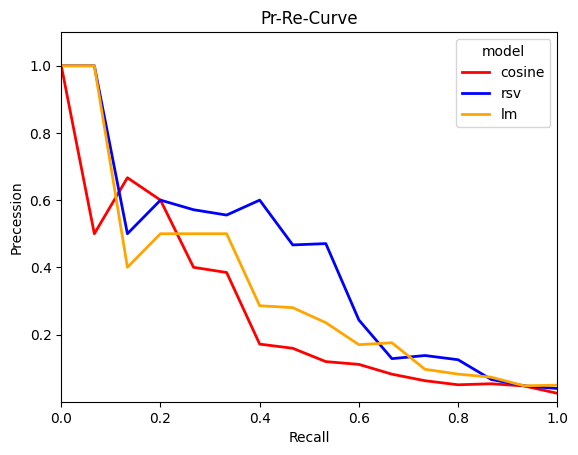

In [29]:
print(f"Query({query_number}):", queries[query_number])
print(f"===== precession-recall curve (for query {query_number}) =====")
pr_re_plot(axs, ays, labels=["cosine", "rsv", "lm"], colors=["red", "blue", "orange"])

In [30]:
def eleven_point_interpolate_precisions(ax, ay):
    ax = np.array(ax)
    ay = np.array(ay)

    standard_recalls = np.linspace(0.0, 1.0, 11)
    y_interp = []

    for recall_point in standard_recalls:
        max_precision = np.max(ay[ax >= recall_point])
        y_interp.append(max_precision)

    return np.array(y_interp)

Query(45): 
what is the combined effect of surface heat and mass transfer on
hypersonic flow .

===== 11-point interpolated precession-recall curve (for query 45) =====


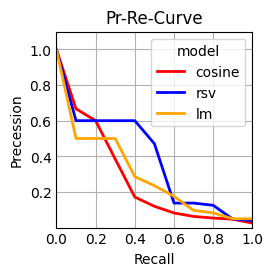

In [31]:
interpolated_ays = [
    eleven_point_interpolate_precisions(ax, ay) for ax, ay in zip(axs, ays)
]
standard_axs = [np.linspace(0.0, 1.0, 11) for _ in range(len(interpolated_ays))]
print(f"Query({query_number}):", queries[query_number])
print(
    f"===== 11-point interpolated precession-recall curve (for query {query_number}) ====="
)
pr_re_plot(
    standard_axs,
    interpolated_ays,
    labels=["cosine", "rsv", "lm"],
    colors=["red", "blue", "orange"],
)

In [32]:
query_numbers = range(0, NUM_QUERIES)

sum_ays = [np.zeros(11) for _ in results_lists]

for query_number in query_numbers:
    results_lists = [
        score_func(query=queries[query_number], k=0)
        for score_func in [cosine_score, rsv_score, language_model_score]
    ]

    for model, results in enumerate(results_lists):
        precessions, recalls = calc_precession_recall_for_all_k(query_number, results)

        sum_ays[model] += eleven_point_interpolate_precisions(ax=recalls, ay=precessions)

avg_ays = [ay/len(query_numbers) for ay in sum_ays]

avg_ays

[array([1.        , 0.46661663, 0.41903878, 0.33720956, 0.29110594,
        0.26900955, 0.19690993, 0.17293608, 0.1427423 , 0.10672844,
        0.10127902]),
 array([1.        , 0.5427728 , 0.48918831, 0.41077323, 0.36721977,
        0.33082308, 0.22564293, 0.18841821, 0.15469251, 0.12048785,
        0.11328891]),
 array([1.        , 0.50937682, 0.44351953, 0.36364497, 0.3195934 ,
        0.27764637, 0.19562337, 0.16015768, 0.13268892, 0.10385231,
        0.09843285])]

===== 11-point interpolated average precision (for queries 0 ~ 224) =====


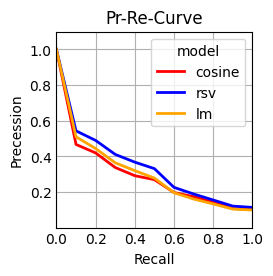

In [33]:
standard_axs = [np.linspace(0.0, 1.0, 11) for _ in range(len(avg_ays))]
print(
    f"===== 11-point interpolated average precision (for queries {query_numbers[0]} ~ {query_numbers[-1]}) ====="
)
pr_re_plot(
    standard_axs,
    avg_ays,
    labels=["cosine", "rsv", "lm"],
    colors=["red", "blue", "orange"],
)

As we can see in the above curve, rsv_score(probabilistic model) has a better performance in all recalls. After that language_model and vector_space_model are second and third respectively.

After recall 0.6, all three model perform approximately the same.

Lets evaluate one more criteria for this three IR systems

#### How fast these models are?

In [34]:
import time

In [35]:
start = time.time()
for query in queries:
    cosine_score(query, k=0)
end = time.time()
print(end-start)

8.25025463104248


In [36]:
start = time.time()
for query in queries:
    rsv_score(query, k=0)
end = time.time()
print(end-start)

8.325571060180664


In [37]:
start = time.time()
for query in queries:
    language_model_score(query, k=0)
end = time.time()
print(end-start)

2.6202280521392822


As we can see the searching time for cosine_score and rsv_score are close but language model is significantly faster.

Overall with this implementations, rsv_score and language model are better than cosine score; because rsv performs better and language model is faster.